# 情感分析
在此 notebook 中，你将从头开始构建一个端到端情感分类系统。


## 第 1 步：探索数据！

我们要使用的数据集在自然语言处理研究人员人群当中很受欢迎，通常称为 [IMDb 数据集](http://ai.stanford.edu/~amaas/data/sentiment/)。它由网站 [imdb.com](http://www.imdb.com/) 上的影评组成，每条影评都被标记为 **pos**itive（如果影评人喜欢这部电影），否则被标为 **neg**ative'。

> Maas, Andrew L. 等。[学习情感分析单词向量](http://ai.stanford.edu/~amaas/data/sentiment/)。发布于_第 49 届计算语言学协会年度大会：人类语言技术公报_。计算语言学协会，2011 年。

我们已经为你提供该数据集。你可以通过执行以下 Python 单元格加载该数据集。

In [3]:
%%time
import os
import glob

def read_imdb_data(data_dir='data'):
    """Read IMDb movie reviews from given directory.
    
    Directory structure expected:
    - data/
        - train/
            - pos/
            - neg/
        - test/
            - pos/
            - neg/
    
    """

    # Data, labels to be returned in nested dicts matching the dir. structure
    data = {}
    labels = {}

    # Assume 2 sub-directories: train, test
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}

        # Assume 2 sub-directories for sentiment (label): pos, neg
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            # Fetch list of files for this sentiment
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            # Read reviews data and assign labels
            for f in files:
                with open(f,'rb') as review:
                    data[data_type][sentiment].append(review.read().decode('utf-8'))
                    labels[data_type][sentiment].append(sentiment)
            
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
    
    # Return data, labels as nested dicts
    return data, labels


data, labels = read_imdb_data()
print("IMDb reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
        len(data['train']['pos']), len(data['train']['neg']),
        len(data['test']['pos']), len(data['test']['neg'])))

IMDb reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg
Wall time: 21.8 s


加载数据后，我们快速查看下其中一条正面影评：

In [4]:
print(data['train']['pos'][2])

Brilliant over-acting by Lesley Ann Warren. Best dramatic hobo lady I have ever seen, and love scenes in clothes warehouse are second to none. The corn on face is a classic, as good as anything in Blazing Saddles. The take on lawyers is also superb. After being accused of being a turncoat, selling out his boss, and being dishonest the lawyer of Pepto Bolt shrugs indifferently "I'm a lawyer" he says. Three funny words. Jeffrey Tambor, a favorite from the later Larry Sanders show, is fantastic here too as a mad millionaire who wants to crush the ghetto. His character is more malevolent than usual. The hospital scene, and the scene where the homeless invade a demolition site, are all-time classics. Look for the legs scene and the two big diggers fighting (one bleeds). This movie gets better each time I see it (which is quite often).


再看一条负面影评：

In [5]:
print(data['train']['neg'][2])

This film lacked something I couldn't put my finger on at first: charisma on the part of the leading actress. This inevitably translated to lack of chemistry when she shared the screen with her leading man. Even the romantic scenes came across as being merely the actors at play. It could very well have been the director who miscalculated what he needed from the actors. I just don't know.<br /><br />But could it have been the screenplay? Just exactly who was the chef in love with? He seemed more enamored of his culinary skills and restaurant, and ultimately of himself and his youthful exploits, than of anybody or anything else. He never convinced me he was in love with the princess.<br /><br />I was disappointed in this movie. But, don't forget it was nominated for an Oscar, so judge for yourself.


我们还可以对影评进行 wordcloud 可视化。

In [6]:
# Installing wordcloud
!pip install wordcloud

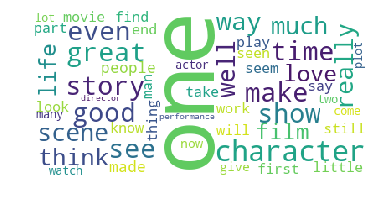

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

sentiment = 'pos'

# Combine all reviews for the desired sentiment
combined_text = " ".join([review for review in data['train'][sentiment]])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50,
        # update stopwords to include common words like film and movie
        stopwords = STOPWORDS.update(['br','film','movie']))

# Generate and plot wordcloud
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

尝试将情感改为 `'neg'`，看看能否看出这两个 wordcloud 之间的明显区别。

### TODO：形成训练集和测试集

你已经查看了原始数据，现在请将正面和负面文档结合到一起，获得一个统一的训练集和一个统一的测试集。

In [8]:
from sklearn.utils import shuffle

def prepare_imdb_data(data):
    """Prepare training and test sets from IMDb movie reviews."""
    
    # TODO: Combine positive and negative reviews and labels(dicts)
    data_train = data['train']['pos'] + data['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']
    
    # TODO: Shuffle reviews and corresponding labels within training and test sets
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test


data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

IMDb reviews (combined): train = 25000, test = 25000


## 第 2 步：预处理

你可能已经在示例影评中注意到了，原始数据包含 HTML。因此需要<font color=blue>删除 HTML 标记</font>。我们还需要删除非字母字符、通过将大写字母转换为小写来标准化大写字母、标记化、删除停用词并词干提取每个文档中的剩余单词。

### TODO：将每条影评转换为单词

下个任务是完成执行所有这些步骤的函数 `review_to_words()`。为了方便起见，在下面的 Python 单元格中，我们提供了完成这些预处理步骤可能需要的所有库。确保导入所有这些库（如果不能导入，请从终端通过 pip 安装，并重新运行/导入。）

In [9]:
# BeautifulSoup to easily remove HTML tags
from bs4 import BeautifulSoup 

# RegEx for removing non-letter characters
import re

# NLTK library for the remaining steps
import nltk
nltk.download("stopwords")                        # download list of stopwords (only once; need not run it again)
from nltk.corpus import stopwords                # stopwords

from nltk.stem.porter import *
stemmer = PorterStemmer()                        # word stemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
from nltk.stem.wordnet import WordNetLemmatizer

wnl = WordNetLemmatizer()
# words_net = [WordNetLemmatizer().lemmatize(w, pos='v') for w in words_cleaned]
print(wnl.lemmatize('was', 'v'))
wnl.lemmatize('built')

be


'built'

In [11]:
%%time
def review_to_words(review):
    """Convert a raw review string into a sequence of words."""
    
    # TODO: Remove HTML tags and non-letters,
    #       convert to lowercase, tokenize,
    #       remove stopwords and stem
    text = BeautifulSoup(review, "html5lib").get_text()               # delect HTML mark
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())                 # delect symbol(better is stem extraction )
    words = text.split()
    words = [w for w in words if w not in stopwords.words("english")] # Stopwords
    words = [PorterStemmer().stem(w) for w in words]                  # word stem extraction
    
    # Return final list of words
    return words


review_to_words("""This is just a <em>test</em>.<br/><br />But if it wasn't a test, it would make for a <b>Great</b> movie review!""")

Wall time: 0 ns


['test', 'test', 'would', 'make', 'great', 'movi', 'review']

完全实现函数 `review_to_words()` 后，我们可以将其应用到训练数据集和测试数据集中的所有影评上。可能需要一段时间，因此构建以下机制：将数据写入缓存文件中，并稍后从缓存文件中获取数据。

In [12]:
%%time
import pickle

cache_dir = os.path.join("cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test


# Preprocess data
words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train, data_test, labels_train, labels_test)

# Take a look at a sample
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])
print('******OK******')

Read preprocessed data from cache file: preprocessed_data.pkl

--- Raw review ---
Don't waste time reading my review. Go out and see this astonishingly good episode, which may very well be the best Columbo ever written! Ruth Gordon is perfectly cast as the scheming yet charming mystery writer who murders her son-in-law to avenge his murder of her daughter. Columbo is his usual rumpled, befuddled and far-cleverer-than-he-seems self, and this particular installment features fantastic chemistry between Gordon and Falk. Ironically, this was not written by heralded creators Levinson or Link yet is possibly the densest, most thoroughly original and twist-laden Columbo plot ever. Utterly satisfying in nearly every department and overflowing with droll and witty dialogue and thinking. Truly unexpected and inventive climax tops all. 10/10...seek this one out on Netflix!

--- Preprocessed words ---
['blond', 'blonder', 'pamela', 'anderson', 'denis', 'richard', 'almost', 'everi', 'scene', 'want',

## 第 3 步：提取词袋特征

预处理每个文档后，我们可以将每个文档转换为 __词袋特征表示法__ 。注意，我们需要仅根据训练数据创建此转换，因为根本不能查看测试数据！

这里使用的字典或_词汇表_ $V$（训练集中的文档共享的单词集合）将用于训练我们的监督式学习算法。必须按照相同的方式转换日后的测试数据，以便能够应用学习的模型进行预测。因此，必须存储转换/词汇表。

> **注意**：训练集中的单词集合不一定和测试集完全一样。如果在测试期间遇到之前没见过的单词，该怎么办？遗憾的是，我们需要忽略它，或将其替换为特殊标记 `<UNK>`。

### TODO：计算词袋特征

实现 `extract_BoW_features()` 函数，将其应用到训练数据集和测试数据集，并将结果分别存储在 `features_train` 和 `features_test` NumPy 数组中。选择一个合理的词汇表大小（例如 $|V| = 5000$），并仅保留出现次数为前 $|V|$ 的单词，忽略其余单词。此数字也是词袋矩阵的列数。

> **提示**：你可能会发现 scikit-learn 中的 `CountVectorizer` 很有用。此外确保保存词袋转换以供日后使用。

In [13]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer                # BOW count
from sklearn.externals import joblib                                       # strengthen version of 'pickle' for storing 'numpy.ndarray'

In [14]:
# joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # TODO: Fit a vectorizer to training documents and use it to transform them
        # NOTE: Training documents have already been preprocessed and tokenized into words;
        #       pass in dummy functions to skip those steps, e.g. preprocessor=lambda x: x
        vectorizer = CountVectorizer(max_features=vocabulary_size,
                preprocessor=lambda x: x, tokenizer=lambda x: x)     # already preprocessed
        features_train = vectorizer.fit_transform(words_train).toarray()

        # TODO: Apply the same vectorizer to transform the test documents (ignore unknown words)
        features_test = vectorizer.transform(words_test).toarray()
        
        # NOTE: Remember to convert the features using .toarray() for a compact representation
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary


# Extract Bag of Words features for both training and test datasets
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

# Inspect the vocabulary that was computed
print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

# Sample
print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

Read features from cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['stink', 'mass', 'friend', 'maintain', 'pat', 'lazi', 'springer', 'haunt']

--- Preprocessed words ---
['kid', '50', '60', 'anyth', 'connect', 'disney', 'definit', 'great', 'happen', 'abl', 'get', 'actor', 'actress', 'want', 'best', 'time', 'somehow', 'disney', 'manag', 'screw', 'thing', 'spite', 'abund', 'resourc', 'disney', 'afford', 'best', 'writer', 'best', 'produc', 'director', 'still', 'screw', 'thing', 'movi', 'crap', 'sad', 'thing', 'suspect', 'disney', 'arrog', 'even', 'know', 'movi', 'good', 'bad', 'due', 'talent', 'actor', 'even', 'give', '3', '10']

--- Bag-of-Words features ---
[0 0 0 ... 0 0 0]

--- Label ---
neg


我们尝试为某个训练文档可视化词袋特征向量。

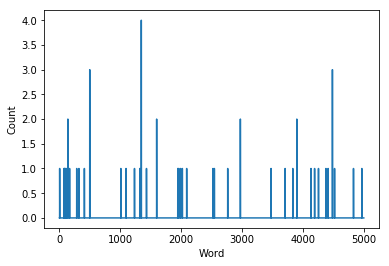

In [15]:
# Plot the BoW feature vector for a training document
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

#### 问题：思考词袋特征表示结果

训练集中的词袋向量平均稀疏程度是多少？换句话说，词袋特征中平均有百分之多少条目为 0？

#### 答案：
```python
len(nz[0])/(features_train.shape[0]*features_train.shape[1]) = 0.016912128
```
### 齐波夫定律

[齐波夫定律](https://en.wikipedia.org/wiki/Zipf%27s_law)是以著名的美国语言学家 George Zipf 命名的，它是一条经验定律，表明给定一个大的文档集合，任何单词的频率与其在频率表中的排名成反比。因此最常见的单词频次大约是第二常见单词的两倍，是第三常见单词的三倍，以此类推。在下面的图表中，我们根据训练集中每个单词的排名绘制了单词的频次图表。

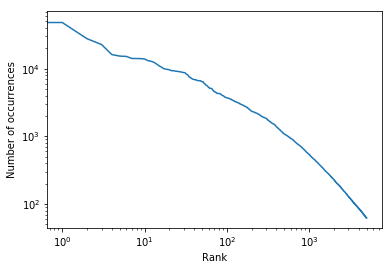

In [16]:
# Find number of occurrences for each word in the training set
word_freq = features_train.sum(axis=0)

# Sort it in descending order
sorted_word_freq = np.sort(word_freq)[::-1]

# Plot 
plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()

In [17]:
sorted_word_freq[0], sorted_word_freq[1], sorted_word_freq[2]

(51695, 48190, 27741)

In [18]:
sorted_word_freq[0]/sorted_word_freq[1], sorted_word_freq[1]/sorted_word_freq[2]

(1.0727329321435983, 1.737139973324682)

#### 问题：齐波夫定律

最常见单词的总频次是多少？第二常见单词的总频次呢？你的数字遵守齐波夫定律定律吗？如果不遵守，原因是？

#### 答案：
```
(51695, 48190, 27741), 
(1.0727329321435983, 1.737139973324682)
不遵守，因为训练文档总量不大，无法得到可信结果
```

### TODO：标准化特征向量

词袋特征很好理解，因为它们是简单的单词计数。但是字数可能差别很大，之后可能会在管道中导致学习算法出错。因此，在继续之前，我们标准化词袋特征向量，使其具有统一的长度。

这样可以确保每个文档的表示结果保留统一的特征成分混合结果，防止字数很多的文档比字数更少的文档影响更大。

In [19]:
import sklearn.preprocessing as pr

# TODO: Normalize BoW features in training and test set
features_train = pr.normalize(features_train, axis=1)
features_test = pr.normalize(features_test, axis=1)

## 第 4 步：使用词袋特征进行分类

正确转换所有数据后，我们可以将数据馈送到分类器中。要获得基准模型，我们从  scikit-learn 中选择算法（具体而言，是 [`GaussianNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)）训练一个朴素贝叶斯分类器，并通过测试集评估分类器的准确率。

In [20]:
from sklearn.naive_bayes import GaussianNB

# TODO: Train a Guassian Naive Bayes classifier
clf1 = GaussianNB(var_smoothing=1e-3)
clf1.fit(features_train, labels_train)

# Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        clf1.__class__.__name__,
        clf1.score(features_train, labels_train),
        clf1.score(features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.83216, test = 0.7524


<font color=blue> __基于树的算法__  通常在 `词袋特征` 上效果很好 </font>，因为树结构可以 __弥补词袋的高度不连续性和稀疏特性__ 。
在下个任务中，你将通过使用  scikit-learn 的梯度提升决策树分类器(`GBDT`)改善朴素贝叶斯分类器的性能。

### TODO：梯度提升决策树分类器

使用  scikit-learn 中的 [`GradientBoostingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) 分类词袋数据。此模型有大量参数。我们使用某些默认参数，并为你预设了剩余参数，但是 `n_estimators` 由你来设置。请为该参数设置一个合适的值，用其分类数据，并报告对于朴素贝叶斯算法，你的准确率提高了多少。 

> **提示**：请使用交叉验证、网格搜索或信息准则方法等模型选择技巧得出超参数的最佳值。

In [21]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 32
lr = 0.8
dep= 5
dep_l = [1,2,3,4,5,6,7,8,9]
result_l = []
def classify_gboost(X_train, X_test, y_train, y_test):        
    # Initialize classifier
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=lr, max_depth=dep, random_state=0)

    # TODO: Classify the data using GradientBoostingClassifier
    clf.fit(X_train, y_train)

    # TODO(optional): Perform hyperparameter tuning / model selection

    # TODO: Print final training & test accuracy
    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(X_train, y_train),
            clf.score(X_test, y_test)))
    result_l.append([clf.score(X_train, y_train), clf.score(X_test, y_test)])
    # Return best classifier model
    return clf

clf2 = classify_gboost(features_train, features_test, labels_train, labels_test)

[GradientBoostingClassifier] Accuracy: train = 0.90108, test = 0.83156
Wall time: 7min 28s


dep: 1-9
```python
[[0.79668, 0.79192],
 [0.83048, 0.822],
 [0.85604, 0.82936],
 [0.87836, 0.83012],
 [0.90108, 0.83156],
 [0.92104, 0.82984],
 [0.9424, 0.82732],
 [0.95588, 0.8248],
 [0.9658, 0.81924]]
```

### TODO：对抗测试

写一条简短的影评来迷惑你的机器学习模型吧！这条影评应该有明显的正面或负面情感，但是模型将分类错误。

> **提示**：你可能需要利用词袋架构最大的薄弱之处！

In [23]:
# TODO: Write a sample review and set its true sentiment
my_review = "I thought it would be just like all the other boring sequels that are coming out everyday. But had I not gone, I would've missed out on a treat. Not only was it not boring, it kept me at the edge of my seat till the end."
true_sentiment = 'pos'  # sentiment must be 'pos' or 'neg'

# TODO: Apply the same preprocessing and vectorizing steps as you did for your training data
my_words = review_to_words(my_review)
vectorizer = CountVectorizer(vocabulary=vocabulary,
                             preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed
my_bow_features = vectorizer.transform([my_words]).toarray()  # pass an array of 1 element

# TODO: Then call your classifier to label it
predicted_sentiment = clf2.predict(my_bow_features)[0]
print("--- My review ---")
print(my_review)
print("\n--- Preprocessed words ---")
print(my_words)
print("\nTrue sentiment: {}, predicted sentiment: {}".format(true_sentiment, predicted_sentiment))

--- My review ---
I thought it would be just like all the other boring sequels that are coming out everyday. But had I not gone, I would've missed out on a treat. Not only was it not boring, it kept me at the edge of my seat till the end.

--- Preprocessed words ---
['thought', 'would', 'like', 'bore', 'sequel', 'come', 'everyday', 'gone', 'would', 'miss', 'treat', 'bore', 'kept', 'edg', 'seat', 'till', 'end']

True sentiment: pos, predicted sentiment: neg


## 延伸

你可以通过多种方式继续完善此 notebook。每种方式都有一些挑战性，但是会带来非常有意义的经验。

- 首先是通过尝试不同的架构、层级和参数，提高模型的准确率。在没有花费过长训练时间的情况下，准确率能达到多少？如何防止过拟合？

- 然后，你可能需要将模型部署为移动应用或网络服务。如果要进行此类部署，你需要执行哪些操作？如何接受新的影评、将其转换为适合模型的格式，并进行实际预测？（注意，你在训练过程中使用的环境可能不可用了。）

- 对于此 notebook，我们做出了一个简化：将任务限制为二元分类任务。数据集实际上包含更精细的评分，由每个影评的文件名表示（格式为 `<[id]_[rating].txt>`，其中 `[id]` 是唯一标识符，`[rating]` 的范围是 1-10；注意中性评分 > 4 或 < 7 已被排除）。如何修改 notebook，以对评分执行递归算法？在什么情形下，递归比分类更有用，相反情况呢？

无论你朝着哪个方向发展，都确保与其他学员分享你的结果和学习成果，将结果分享到博客、论坛上，并参与在线竞争项目。这也是吸引潜在雇主的极佳方式！

__END__